# Markov processes and Markov chains

A Markov process is any stochastic process where the probabilities of the systems future behavior is given solely by its current state, and not its past state. This property is sometimes referred to as a "memoryless" system. Markov chains are a specific type of markov process that occur in discrete steps, or discrete states. Another name typically used for Markov processes/chains are Markov models.

Markov processes are analogous to difference or differential equations, because the current state of the system is what decides how the system will continue to develop over time. A Markov model is therefore like a stochastic differential equation.


```{figure} ../../figures/markov_chain.png
---
width: 500px
name: markov_chain
alt: markov_chain
---
**A Markov Chain:** A Markov Chain can be drawn out with the the different states as circles, and arrows indicating the transitions between them. This is an example of a three state markov chain. The numbers by the arrows indicate the probability of each transition. For example, if the system is in state A it has a 60% likelihood of staying in A, and a 40% likelihood of transitioning into state B.
```


## Some Plotting setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

np.random.seed(123456789)

## The Ehrenfest  Experiment

The Ehrenfest experiment is an example of a Markov chain. In this experiment, imagine you have two urns, with $m$ balls spread between the two urns. For every iteration, you pick one ball at random, and then move it from the urn it is currently in, to the other one.


```{figure} ../../figures/ehrenfest.png
---
width: 300px
name: ehrenfest
alt: ehrenfest
---
```

This is an example of a Markov process, because the probabilities of moving a ball from one urn to the other is given solely by how many balls are currently in each urn, i.e., it depends solely on the current *state*.

If we assume we have $m$ balls in total, then we can define the current state of the system as the number of balls in the left urn. This urn can have $0, 1, \ldots, m$ balls, so with $m$ balls in total, we have $m+1$ possible states in our system.

Let us model this markov process as a Monte Carlo process, i.e., a random walk. For each step of the iteration, we need to first pick a ball at random. If we have $m$ balls, we can do this with `np.random.randint(m)`. Next we check wether we picked a ball from the left urn, in which case it is moved to the right, or vice versa.

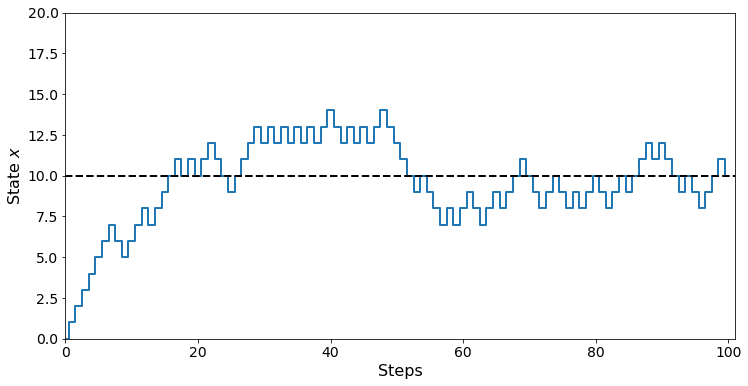

In [2]:
N = 100 # Number of steps
m = 20   # Total number of balls

# State of the system (balls in left urn)
x = np.zeros(N+1)
x[0] = 0

for i in range(N):
    ball = np.random.randint(20)
    if ball < x[i]:
        x[i+1] = x[i] - 1
    else:
        x[i+1] = x[i] + 1

plt.step(range(N+1), x, where='mid')
plt.axhline(m/2, linestyle='--', color='black')
plt.axis((0, N+1, 0, 20))
plt.xlabel('Steps')
plt.ylabel('State $x$')
plt.show()

Looking at the plot, we can see that curve rises quickly in the beginning, men then flattens out a bit. This is because we start at $x=0$, i.e., with 0 balls in the left urn. This means it is overwhelmingly likely to pick a ball in the right urn, increasing $x$. However, as $x$ grows, there are now more balls in the left urn, and so the probability of picking either urn is growing. When $x=10$ there is an equal number of balls in either urn, meaning it is equally likely to take a step in either direction.

Our model is just like the 1D uniform random walker, but the probability is only uniform if $x=10$, as soon as the walker steps away from this value, it has a higher probability of walking back to $x=m/2$ than further away.


If we increase the number of steps taken, we see that there is considerable swinging around the $m/2$ mark, but that we never get really big divergence from this mean value.

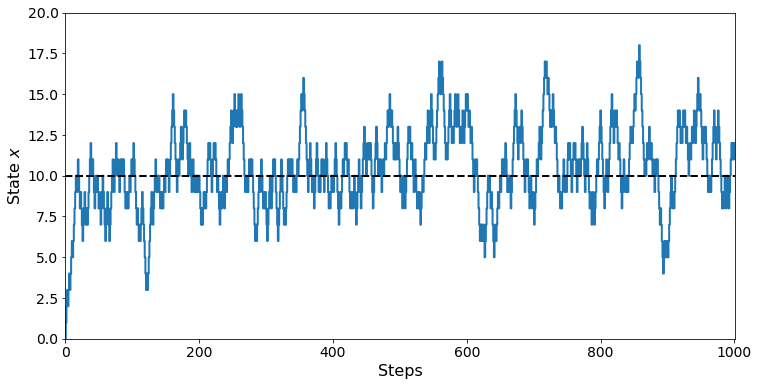

In [3]:
N = 1000 # Number of steps
m = 20   # Total number of balls

# State of the system (balls in left urn)
x = np.zeros(N+1)
x[0] = 0

for i in range(N):
    ball = np.random.randint(20)
    if ball < x[i]:
        x[i+1] = x[i] - 1
    else:
        x[i+1] = x[i] + 1

plt.step(range(N+1), x, where='mid')
plt.axhline(m/2, linestyle='--', color='black')
plt.axis((0, N+1, 0, 20))
plt.xlabel('Steps')
plt.ylabel('State $x$')
plt.show()

## Analyzing the probabilities of the system with Markov Chains

We just performed a Monte Carlo random walk on our system. But we can also analyze the system in a different way. In our random walk, we express the specific state the system is in as an integer in the range $[0, m]$, i.e., we model the system as being in a given state at any time.

An alternative to this is instead to talk about the *probability* of the system to be in a given state. We can express this as a given *probability* vector, $\bar{p}$. This vector would be $m+1$ elements long, and the element $p_{i}$ would express the probability that the system is in state $i$. As this probability changes over time, we will denote the probability vector after $N$ steps as $\bar{p}_N$.

As the system starts in $x=0$, we know that
$$\bar{p}_0 = (1, 0, 0, \ldots, 0).$$

For the first step of the iteration, we know we will have to move to $x=1$ with 100% likelihood, so we get

$$\bar{p}_1 = (0, 1, 0, \ldots, 0).$$

But what happens now? The probability of moving another ball from the right urn to the left is $19/20$, i.e., 95\%. But there is a small chance of $1/20$, or 5\%, of moving the ball back. Thus, the probability vector splits:

$$\bar{p}_2 = (\frac{1}{20}, 0, \frac{19}{20}, 0, 0, \ldots, 0).$$

Performing more steps by hand quickly becomes tedious. The point is that we can model the *probability* of being in each possible state. This vector is often called the *probability distribution* of the system, as it tells us how the probability is *distributed* across the many states. If you think this concept is too abstract, it can help envision it as releasing a large number of random walkers, say a million. Then $\bar{p}$ denotes the ratio of the walkers in the different states over time.


### The Transition Matrix

If we want to model $\bar{p}$ over time, we need to find some way to compute $\bar{p}_{N+1}$ from $\bar{p}_N.$ This is done with something called a *transition matrix* or alternatively a *propagator matrix*. This matrix denotes the probability of transitioning between states. It can be set up in a few different ways, but we want to generate a matrix $M$, so that the matrix element $M_{ij}$ is the probability of transitioning from $j$ to $i$. When generated this way, we can easily iterate the probability vector by matrix-vector multiplication:
$$\bar{p}_{N+1} = M\bar{p}_N.$$

Let us try this for our current problem, the Ehrenfest experiment. As we have $m+1$ possible states, our transition matrix must have dimensions of $(m+1)\times(m+1)$, as both indices indicate a state. As $M_{i, j}$ indicates the probability of transitioning from $j$ to $i$, we know that

$$M_{x+1, x} = \frac{m-x}{m}, \qquad M_{x-1, x} = \frac{x}{m}.$$

The first term is the probability of the transition $x \to x+1$, this means the step where a ball from the right urn is drawn, increasing $x$ by 1. This happens with probability $(m-x)/m$ as described earlier. The other transition is that we draw a ball from the left urn, decreasing $x$, so $x \to x-1$.

In [4]:
M = np.zeros((m+1, m+1))

for x in range(1, m):
    M[x-1, x] = x/m
    M[x+1, x] = (m-x)/m

M[1, 0] = 1
M[m-1, m] = 1

Note that we are using a loop to set both transitions from each state: $x\to x+1$ and $x\to x-1$. However, we cannot get the ends correct inside the loop, as there is no $x \to x-1$ at the lower end when $x=0$, and similarly there is no $x\to x+1$ when $x=m$. This is included in the mathematics, because the expressions actually give 0 transition rates for these transitions, but if we try to set them to 0 in our code, we get an IndexError.


With the transition matrix generated, let's plot it

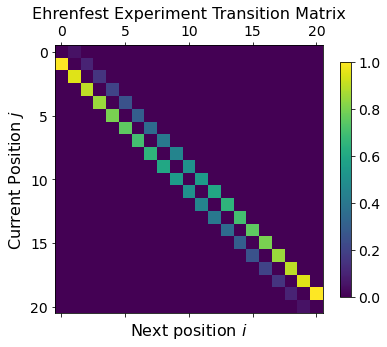

In [5]:
plt.matshow(M)
plt.colorbar(shrink=0.7)
plt.xlabel('Next position $i$')
plt.ylabel('Current Position $j$')
plt.title('Ehrenfest Experiment Transition Matrix')
plt.show()

Analyzing the transition matrix by looking at it is quite tricky, as it is quite an abstract quantity with a lot of information in it. However, there is a simply test we can perform to see if it is reasonable. Note that because
$$\bar{p}_N = (p_{0,N}, p_{1, N}, \cdots, p_{i, N}, \cdots)$$

represents a probability distribution, the sum of all the elements of $\bar{p}$ but be 1:

$$\sum_i p_{i, N} = 1.$$
But this must be the case at any time step as well, so we have
$$\sum_i p_{i, N} = 1\ \forall\ N.$$
($\forall$ means "for all").

If the sum of $\bar{p}$ should remain at 1 for each time step, this puts a constraint on the transition matrix $M$, which is that it cannot make $\bar{p}$ grow or shrink. Without going through all the linear algebra, this means that each column of $M$ must also sum to 1:

$$\sum_i M_{i, x} = 1.$$
This statement is the same as saying as the sum of all transitions out of state $x$ must be 1.

We can check that our current matrix satisfies the condition:

In [6]:
assert np.all(np.isclose(np.sum(M, axis=0), 1.0))

This expression first sums each column of the matrix with `np.sum(M, axis=0)`. This should in theory give a vector with only ones. However, because we are computing with floats, we use `np.isclose` instead of `==` to check this, as we might have very tiny deviations from precisely 1.0. The result of `np.isclose` is a vector of boolean values. We want all of these booleans to be true. If even a single column sums to something different from 1, we will get in trouble. We therefore use `np.all`. Finally we use an `assert`, if everything is normal and good, we keep going, if something is wrong, we need to fix it right away.

It is a good idea to always use such an assertion when setting up a transition matrix, as it is easy to mess up an element somewhere.


### Using the transition matrix to compute $\bar{p}$

Let us instead use it to compute the probability vector, $\bar{p}$, over time.

In [7]:
N = 100

p = np.zeros((m+1, N+1))
p[0, 0] = 1

for k in range(N):
    p[:, k+1] = M @ p[:, k]

Note that we use `np.dot` to compute the matrix-vector multiplication $M\cdot p$. This is because `M*p` would not work in the desired way. Instead we could have written `M @ p`, because `@` is the matrix multiplication operator, introduced with Python 3.6.

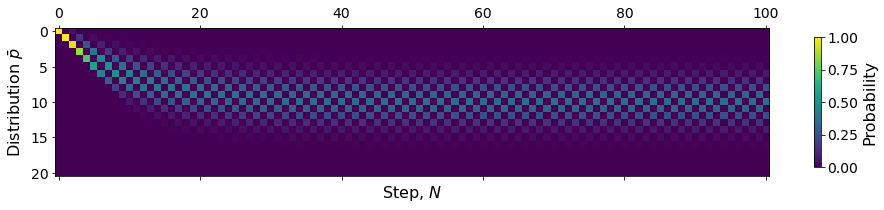

In [8]:
plt.matshow(p)
plt.xlabel('Step, $N$')
plt.ylabel(r'Distribution $\bar{p}$')
plt.colorbar(shrink=0.7, label='Probability')
plt.show()

We see the same trend as we saw for our single walker. As we start at step 0, the probability is collected 100% in $x=0$ as this is our start point. As we iterate, the probability goes towards the mean $x=10$ but also spreads out into a thicker band. We see that the probability of finding the system in states $x\in[5, 15]$ is quite likely, but unlikely outside this interval.

Another thing we can clearly see from the figure is a distinct *checkerboard* pattern. This pattern emerges because our system *has to* transition for each step. We start of in $x=0$ at $N=0$. Now, for each step, $x$ must increase or decrease by exactly 1. This means $x$ will jump from an even to odd number for each iteration, no matter what. Thus only even values of $x$ will have any probability for even steps $N$ and vice versa for odd steps. This gives the distinct checkerboard pattern.


### Steady state

Looking at $\bar{p}_N$, we can see that it stabilizes over time, this is known as the *equilibrium* of the system, and we can say the system is in a *steady state*. Now, we started with $x=0$, which is far away from the steady state, yet the system equilibrates. In fact, for this system, no matter what initial condition you choose, you will end up in the same steady state. This is the case for many Markov chains, and finding the equilibrium behavior of a model is often a goal.

If we want to get a better understanding of the steady state, we can plot out the final probability density vector $\bar{p}$:

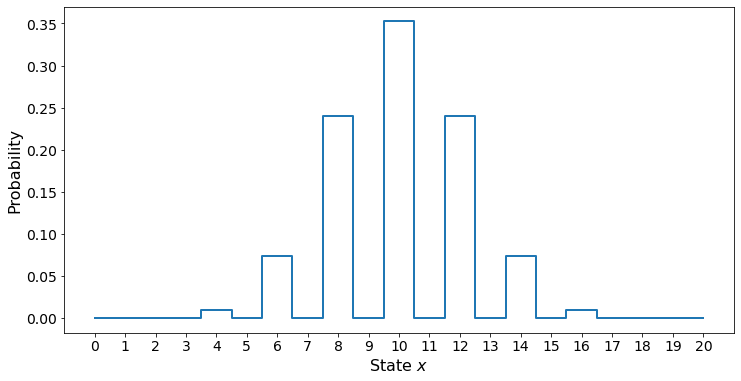

In [9]:
plt.step(range(m+1), p[:, -1], where='mid')
plt.xlabel('State $x$')
plt.ylabel('Probability')
plt.xticks(range(m+1))
plt.show()

Here we see the probability of being in each possible state $x$ after $N=100$ steps. Note that the checkerboard pattern is also visible here, with only the even states being possible. We also see that the probability of being in a state far from $x=10$ falls of rapidly, being incredibly likely when we get far away from the mean value.


### The Modified Ehrenfest Experiment

Ehrenfest also proposed a modified version of his experiment. With the exact same setup, we not only choose a ball at random, but we also choose what urn to place it in at random. Let us look at how this changes the behavior of the model.

The modified model does not change the states themselves, as there are still $m+1$ possible states: $x=0, 1, 2, \ldots, m$. What changes are the transition rates between the states. As before, we pick at ball at random. The probability of picking a ball from the left urn is still $x/m$, and picking a ball from the right urn is still $(m-x)/m$. The difference is that after picking a ball, there is a 50% chance we just place it back into the urn it is already in, and only a 50% chance we put it in the other urn.

Because we need to construct a new transition matrix, we name it $Q$ instead of $M$. We then have

$$Q_{x+1, x} = \frac{m-x}{2m}, \qquad Q_{x, x} = \frac{1}{2}, \qquad Q_{x-1, x} = \frac{x}{2m}.$$
Let us generate this matrix:

In [10]:
Q = np.zeros((m+1, m+1))

for x in range(m+1):
    Q[x, x] = 1/2

    if x > 0:
        Q[x-1, x] = x/(2*m)
    if x < m:
        Q[x+1, x] = (m-x)/(2*m)

# Check that all columns sum to 1
assert np.all(np.isclose(np.sum(Q, axis=0), 1))

As our assertion went through, let us move on to modeling the system. We now name our probability vector $\bar{q}$:

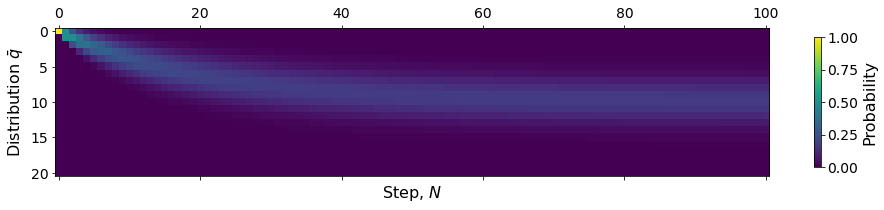

In [11]:
N = 100

q = np.zeros((m+1, N+1))
q[0, 0] = 1

for k in range(N):
    q[:, k+1] = np.dot(Q, q[:, k])

plt.matshow(q)
plt.xlabel('Step, $N$')
plt.ylabel(r'Distribution $\bar{q}$')
plt.colorbar(shrink=0.7, label='Probability')
plt.show()

Comparing the normal and the modified Ehrenfest models, we notice two things. First of, the checkerboard pattern is gone! This is because the model can now also remain in place, therefore, there is no longer any guarantee that the state of the system is even or odd at different times.

In addition to this, we can see that it takes longer before the system reaches its steady state. This makes sense, as the probability of staying put is $1/2$, meaning every other step of the system will tend to be no change. This means we would expect it to take about twice as long for the model to hit its steady state, which we can see that it does.

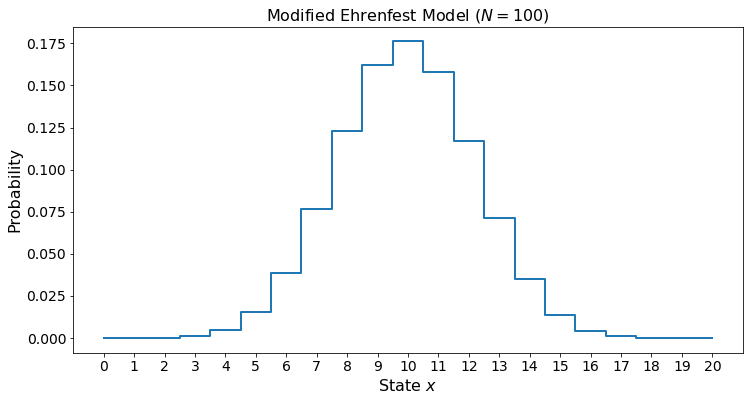

In [12]:
plt.step(range(m+1), q[:, -1], where='mid')
plt.xlabel('State $x$')
plt.ylabel('Probability')
plt.title('Modified Ehrenfest Model ($N=100$)')
plt.xticks(range(m+1))
plt.show()

Again we see that we do not get the checkerboard pattern. In addition we see that there is a slightly higher chance of being to the left of $x=10$ compared to the right. This is because we started the whole system in $x=0$ and it clearly has not had enough time to reach equilibrium. Let us try again with more steps and see.

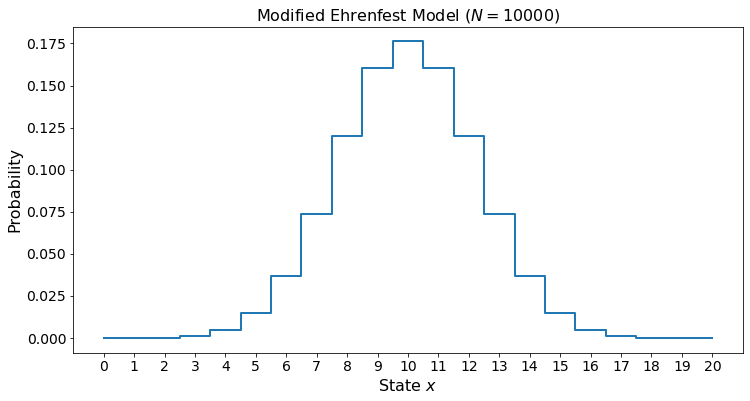

In [13]:
N = 10000

q = np.zeros((m+1, N+1))
q[0, 0] = 1

for k in range(N):
    q[:, k+1] = np.dot(Q, q[:, k])

plt.step(range(m+1), q[:, -1], where='mid')
plt.xlabel('State $x$')
plt.ylabel('Probability')
plt.title('Modified Ehrenfest Model ($N=10000$)')
plt.xticks(range(m+1))
plt.show()

Now the model has had time to equilibrate and reach a fully symmetric state.


## Random Walks and Markov Chains

In the previous lecture we discussed random walks, and now we are talking about markov chains. But what is actually the difference between the two? Put simply, a random walk is actually just a type of markov chain. And so a markov chain is just the generalized concept. However, in practice, people use the terms slightly differently.

The example we just looked at, Ehrenfest's experiment, is an example of a markov chain. This is because the probabilities of moving from one state to another does not depend on time, or on the history of the system. The system itself is *memoryless*.

When analyzing the Ehrenfest system, we first performed a *stochastic* simulation of the system itself. We simply modeled how a single experiment carried out. We can refer to this process as carrying out a random walk. Later we analyzed the probabilities of different states in a completely deterministic manner, it was not a stochastic simulation.

While a random walk is an example of a markov chain, one often uses *random walk* specifically when one talks about stochastic simulation. Another term for such simulations is Monte Carlo Markov Chain (MCMC). Recall that "Monte Carlo" is often used for stochastic algorithms, named after the famous casino. Random walks as a term is therefore often, but not exclusively, used to refer to how the system is studied.



### The Uniform 1D Walker

Last lecture, we looked at random walks with the uniform 1D walker. This is also an example of a markov process, and we can analyze it with markov chains, instead of stochastic simulation. Let us do this.


First we must generate the transition matrix $M$. However, how many possible *states* does our 1D uniform walker actually have? Well, the one we covered in the previous lecture is an *unbounded* walker, the longer you let it carry on, the further away from the origin it gets. Therefore, there's in theory an infinite number of states. This is a bit tricky for us to deal with, so instead, let us look at a *bounded walker*.

A bounded walker is a walker that walks freely and uniformly within its domain, but at the boundary of the domain there are hard walls, and so if it walks all the way out there, it cannot pass through the walls.

Let us say our walker starts in $x=0$, and cannot walk further than 50 in either direction, i.e., the boundaries are at $x=-50$ or $x=50$. This means the system has 101 states ($x \in [-50, 50]$). For each step of the walker, it takes a step to the left or right with equal probability, so

$$M_{i+1, i} = 0.5, \qquad M_{i-1, i} = 0.5.$$

As before, we need to be especially careful at the boundary. If the walker tries to walk through the boundaries, it is not allowed to do so, and instead stays put, so
$$M_{0, 0} = 0.5, \quad M_{100, 100} = 0.5$$

In [14]:
states = 101

M = np.zeros((states, states))

for i in range(1, states-1):
    M[i+1, i] = 0.5
    M[i-1, i] = 0.5

M[0, 0] = 0.5
M[1, 0] = 0.5
M[-1, -1] = 0.5
M[-2, -1] = 0.5

assert np.all(np.isclose(np.sum(M, axis=0), 1))

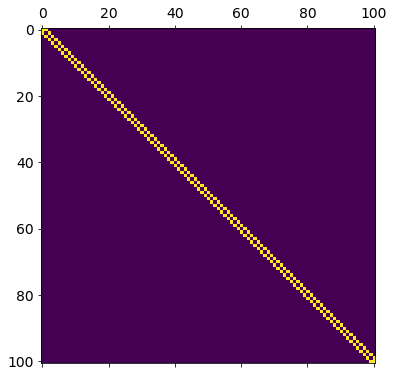

In [15]:
plt.matshow(M)
plt.show()

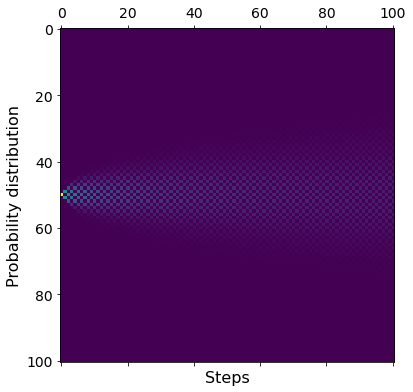

In [16]:
starting_position = (states-1)//2 # start in middle
N = 100

p = np.zeros((states, N+1))
p[starting_position, 0] = 1.0

for i in range(N):
    p[:, i+1] = np.dot(M, p[:, i])

plt.matshow(p)
plt.xlabel('Steps')
plt.ylabel('Probability distribution')
plt.show()

We see that the walker starts at the middle, and then probability spreads out. Again we see a clear checkerboard pattern, because the random walker always takes a step in either direction. Let us close the range where the walker can walk considerably

In [17]:
states = 21

M = np.zeros((states, states))

for i in range(1, states-1):
    M[i+1, i] = 0.5
    M[i-1, i] = 0.5

M[0, 0] = 0.5
M[1, 0] = 0.5
M[-1, -1] = 0.5
M[-2, -1] = 0.5

assert np.all(np.isclose(np.sum(M, axis=0), 1))

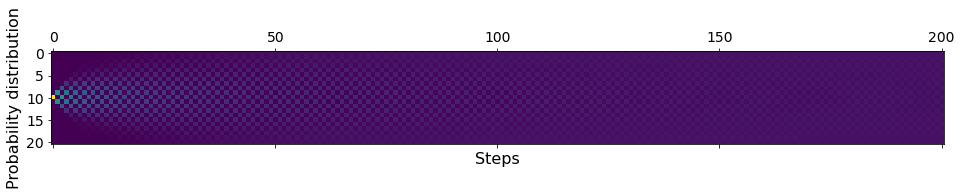

In [18]:
starting_position = (states-1)//2
N = 200

p = np.zeros((states, N+1))
p[starting_position, 0] = 1.0

for i in range(N):
    p[:, i+1] = np.dot(M, p[:, i])

plt.matshow(p)
plt.xlabel('Steps')
plt.ylabel('Probability distribution')
plt.show()

We now see the same checkerboard pattern at the start, but because the walkers at the edge of the domains can remain still for one or more steps, the checkerboard eventually gets washed out. As time moves on, we see that the probability gets completely washed out, meaning the probability of being anywhere within the domain becomes equally likely. This is different from the Ehrenfest model, because in the Ehrenfest model, the system has a tendency to stick close to $x=10$.


### Examples of Markov Chains

Markov process are a generalization of random walks, and so just like we discussed last lecture, they can be used for a large number of applications across a large number of fields. Here, we give to example of use cases of Markov chains.

#### Google's Page Rank algorithm

A popular example of the use of Markov chain comes from the search engine Google. To rank webpages Google envisions the entire world wide web as one giant markov chain. A given webpage is a state in the model. A transition between webpages is a given hyperlink that takes you from one to the other. The Page Rank algorithm is built on the idea that pages with many links to them are more popular and important. In the language of Markov chains, they say that pages with a high transition rate to them should be ranked higher. This is also an example of random walks, because they are essentially ranking pages based on how likely you are to visit them if you were traversing the internet by only clicking random hyperlinks.

Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm was the first algorithm the search engine used. Today they combine the PageRank algorithm with others to provide a final ranking.

#### Modelling ion channels

To understand excitable cells in the body, such as neurons in your brain, or your muscle cells, we need to understand *ion channels*. Ion channels are macromolecules in the cell wall that can open and close to respond to different stimuli. These channels opening start cascading effects in the cell such as a muscle cell contracting or a neuron firing an *action potential*.

These ion channels are huge macromolecules that can shape and distort to enter into different conformational shapes. Some of these shapes allow for ions to pass through, like a tunnel, while other shapes are closed, not allowing any ion transport through. Through a combination of chemistry and physics we can set up elaborate models for how these ion channels open and close. These models are example of Markov models, as the ion channels will be in any number of given states:


```{figure} ../../figures/ion_channel_markov_model.jpg
---
width: 600px
name: ion_channel_markov_model
alt: ion_channel_markov_model
---
```

Such models are crucial to understanding how cells work and react to stimuli. If you for example have a good markov model for an ion channel, you can model how different drugs affect the cell, because the primary effect of most drugs is to change the transition rates between the different states of the ion channel markov model. A drug can for example make certain channels open more easily, or remain open for longer.

Another use for such ion channel markov models is understanding genetic variants and genetic disorder. Brugada syndrome is an example of a genetic disorder leading to abnormal electrical activity in the heart which in turn can lead to sudden death while sleeping. Brugada is especially common among young males in southeast asia. While the cause of the syndrome was unknown for a long time, the genetic cause was discovered in 1998 and is due to a disorder in the cardiac sodium ion channel. This genetic cause can be modelled using markov models, and this has been an important part in understanding the disease and developing treatments for it.

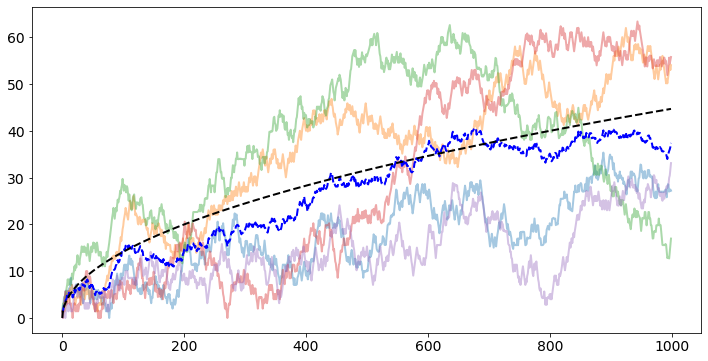

In [19]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
walkers = 5

steps = 2*np.random.randint(2, size=(N, 2, walkers)) - 1
walks = np.cumsum(steps, axis=0)

displacement = np.sqrt(walks[:, 0, :]**2 + walks[:, 1, :]**2)

for walker in range(5):
    plt.plot(range(N), displacement[:, walker], alpha=0.4)

plt.plot(range(N), np.mean(displacement, axis=1), 'b--')
plt.plot(range(N), np.sqrt(2*np.arange(N)), 'k--')
plt.show()

## Chutes and Ladders

For the rest of this lecture we will look at the board game [*Chutes and Ladders*](https://en.wikipedia.org/wiki/Snakes_and_Ladders), which was also the theme for this weeks exercises. It is therefore a good idea to take a look at the exercises before reading these lecture notes, as we will go through and cover the solution.

```{figure} https://upload.wikimedia.org/wikipedia/en/b/ba/Cnl03.jpg
---
width: 300px
name: Cnl03
alt: Cnl03
---
```


### The game with no chutes or ladders

We can start by modelling the game without any chutes and ladders. A normal chutes and ladders board consists of 100 squares. The player starts outside the board, on a virtual square "0". For each turn, the player throws a six-sided die and moves the number of places up on the board. The player is finished when they reach square 100 or above.

Note that this problem is completely 1-dimensional, even though the board it self is a 2D grid, this is because the squares on the board just wraps around and loops back. You could simply cut up the board and put it along one long line.

To model the game as a random walk (Monte Carlo Markov Chain), we use a loop to keep throwing the die until we have reached the goal.

In [20]:
position = 0
rolls = 0
while position < 100:
    position += np.random.randint(1, 7)
    rolls += 1
print(rolls)

30


Simulating a single game like this doesn't tell us much. But we can repeat the process many times, and look at the outcomes:

Lowest number: 21
Highest number: 40
Average number: 29.0859


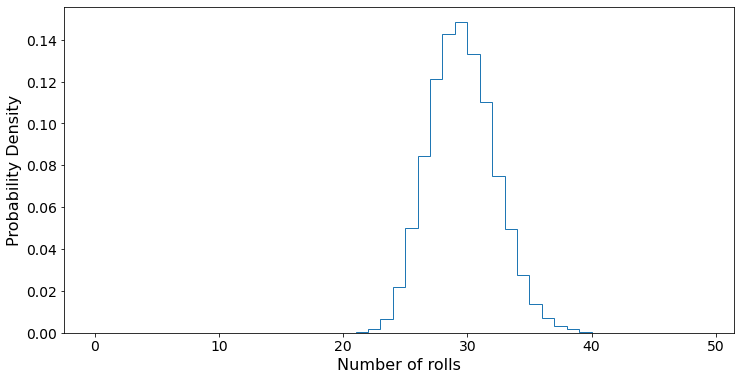

In [21]:
def one_game():
    position = 0
    rolls = 0
    while position < 100:
        position += np.random.randint(1, 7)
        rolls += 1
    return rolls

N = 10000
games = [one_game() for i in range(N)]

print(f"Lowest number: {np.min(games)}")
print(f"Highest number: {np.max(games)}")
print(f"Average number: {np.mean(games)}")

plt.hist(games, bins=range(50), density=True, histtype='step')
plt.xlabel('Number of rolls')
plt.ylabel('Probability Density')
plt.show()

Here we have played 10000 games, and plotted the number of rolls needed to get to the finish line as a histogram. We also plot out the minimum number of rolls needed, the maximum rolls taken and the average. Now, if you take a look at the minimum number of rolls, it is 21, but the theoretical best we can do is to only roll sixes, which would take $100/6 = 16.67 \approx 17$ rolls. However, the probability of getting seventeen sixes in a row is to small to reasonable expect to get it the $N=10000$ games we play here. The average however, should be close to the theoretical average.


Let us repeat our analysis with a non-stochastic Markov Chain, then we first have to make the transition matrix. There are 100 squares, plus the virtual "0" squares, so we have 101 states in our model. When standing in square $i$, we roll a die with 6 outcomes, and so we are equally likely to move to squares $i+1$, $i+2$, $\ldots$, $i+6$. The exception is at the end, where we need to handle the "overshoot" above square 100.

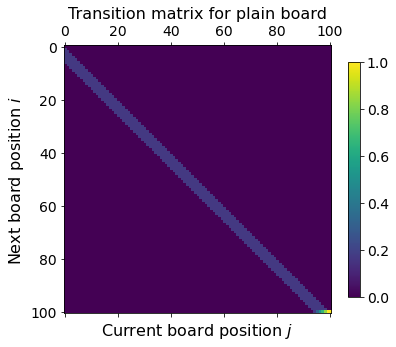

In [22]:
M = np.zeros((101, 101))

for i in range(95):
    M[i+1:i+7, i] = 1/6

# Handle "overshoot"
for i in range(95, 99):
    M[i+1:100, i] = 1/6

# Handle "overshoot"
M[100, 95] = 2/6
M[100, 96] = 3/6
M[100, 97] = 4/6
M[100, 98] = 5/6
M[100, 99] = 1
M[100, 100] = 1

# Check all columns sum to 1
assert np.all(np.isclose(np.sum(M, axis=0), 1.0))

# Plot matrix
plt.matshow(M)
plt.xlabel('Current board position $j$')
plt.ylabel('Next board position $i$')
plt.title('Transition matrix for plain board')
ax = plt.colorbar(shrink=0.7)
plt.show()

With the transition matrix created, we can now model the probability vector $\bar{p}$:

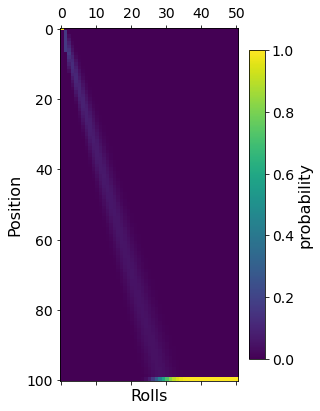

In [23]:
N = 50
p = np.zeros((101, N+1))
p[0, 0] = 1.0

for i in range(N):
    p[:, i+1] = np.dot(M, p[:, i])

plt.matshow(p)
plt.xlabel('Rolls')
plt.ylabel('Position')
plt.colorbar(shrink=0.7, label='probability')
plt.show()

From this plot it is clear that as we carry out more and more rolls, we eventually get to the goal. This Markov chain is an example of an *absorbing* Markov chain, because square "100" sucks up all the probability. After enough rolls, the probability to be finished is 1, and all other squares are 0.

Let us look at how the probability of being finished looks. This would be the final element of $\bar{p}$:

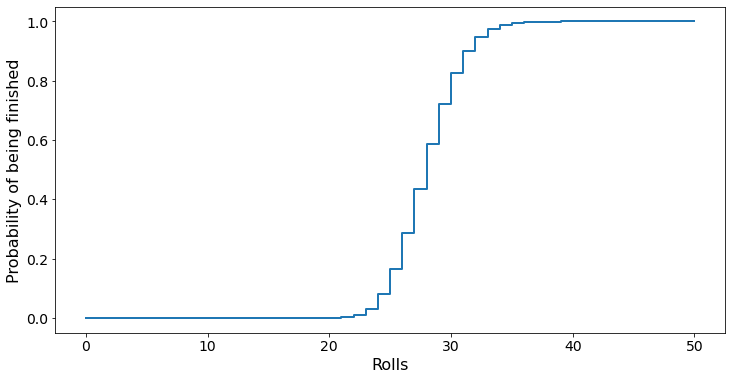

In [24]:
plt.step(range(N+1), p[-1, :])
plt.xlabel('Rolls')
plt.ylabel('Probability of being finished')
plt.show()

This is known as a *cumulative probability distribution* as it shows us the cumulative probability of being finished. In other words, it shows the probability of finishing in $N$ *or more* rolls. If we instead want to figure out the exact number of rolls used, we are looking for the *probability density*, which we can find by taking the derivative of the cumulative probability. Another word for the probability density is the *arrival times*, because it denotes when a player arrives at the finish line.

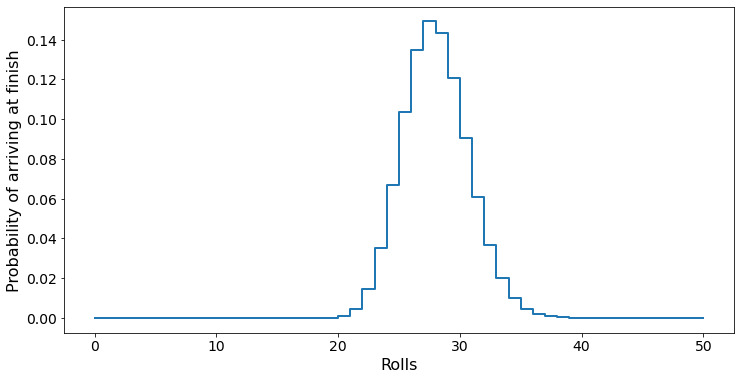

In [25]:
arrival = np.gradient(p[-1, :])

plt.step(range(N+1), arrival)
plt.xlabel('Rolls')
plt.ylabel('Probability of arriving at finish')
plt.show()

This is the same plot as for our monte carlo simulation of the game.


### Adding the Chutes and Ladders

If, after moving, the player hits the start of a ladder or chute, they should move to a different square. We can implement these chutes and ladders as dictionaries. After rolling and moving the player, we check if they landed at the start of a ladder or chute, and if so, move them to the end of that chute/ladder.

We use the chutes and ladders of the *Milton Bradley* version of the game:

In [26]:
ladders = { 1: 38,
            4: 14,
            9: 31,
           21: 42,
           28: 84,
           36: 44,
           51: 67,
           71: 91,
           80: 100}

chutes = {16: 6,
          47: 26,
          49: 11,
          56: 53,
          62: 19,
          64: 60,
          87: 24,
          93: 73,
          95: 75,
          98: 78}

#### Monte Carlo with Chutes/Ladders

To repeat the random walk version of our game with chutes and ladders we simply add an if-test into our for-loop

In [27]:
def one_game():
    position = 0
    rolls = 0
    while position < 100:
        position += np.random.randint(1, 7)
        if position in ladders:
            position = ladders[position]
        elif position in chutes:
            position = chutes[position]
        rolls += 1
    return rolls

one_game()

22

Lowest number: 7
Highest number: 247
Average number: 35.7648


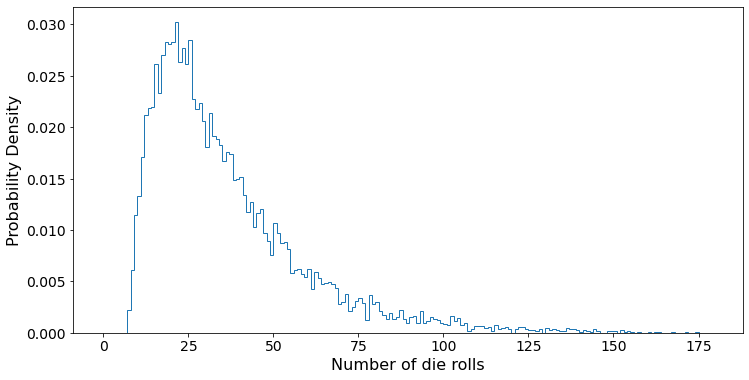

In [28]:
N = 10000
games = [one_game() for i in range(N)]

print(f"Lowest number: {np.min(games)}")
print(f"Highest number: {np.max(games)}")
print(f"Average number: {np.mean(games)}")

plt.hist(games, bins=range(180), density=True, histtype='step')
plt.xlabel('Number of die rolls')
plt.ylabel('Probability Density')
plt.show()

We see that adding the chutes and ladders has pushed down the lowest number of rolls it takes to get to the finish. But it has also increased the maximum number of rolls it takes.


#### Markov Chains with Chutes/Ladders


We now want to repeat our analysis after adding chutes and ladders to our board. The first thing we will need to do is update the propagator matrix.

First we copy the empty board propagator matrix by using `M.copy()`. Then change it to reflect adding the chutes and ladders. To differentiate the two, we call our new matrix $L$.

Updating $L$ to add the chutes and ladders is easier than it might seem. As $L_{i, j}$ denotes the probability of going from $j$ to $i$, simply take any value that would end at the start of a chute and ladder and move that probability to the end of the chute and ladder. For example, let's say we have a ladder going from 12 to 37, then we would simply do:

In [29]:
L[start, :] = 0.
L[end, :] += M[start, :]

NameError: name 'L' is not defined

To add all of our chutes and ladders, we simply loop over them and repeat this process.

In [30]:
L = M.copy()

for start, end in chutes.items():
    L[start, :] = 0.
    L[end, :] += M[start, :]

for start, end in ladders.items():
    L[start, :] = 0.
    L[end, :] += M[start, :]

assert np.all(np.isclose(np.sum(L, axis=0), 1.0))

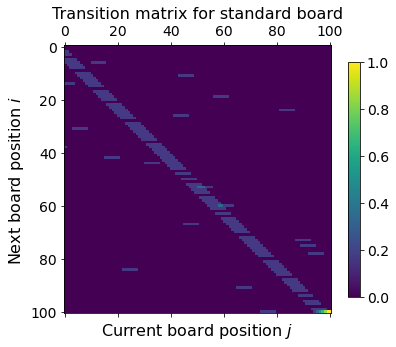

In [31]:
plt.matshow(L);
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Transition matrix for standard board');
plt.colorbar(shrink=0.7);
plt.show()

Now we repeat the process from before to find the probability distribution. This time we call it $\bar{q}$.

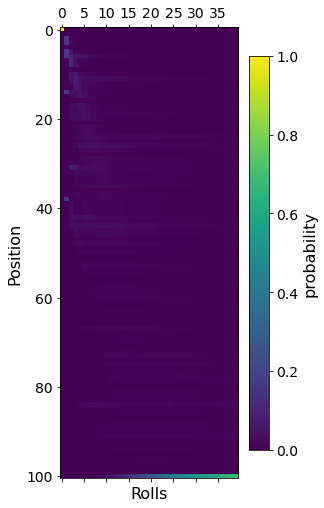

In [32]:
N = 150
q = np.zeros((101, N+1))
q[0, 0] = 1.0

for i in range(N):
    q[:, i+1] = np.dot(L, q[:, i])

plt.matshow(q[:, :40])
plt.xlabel('Rolls')
plt.ylabel('Position')
plt.colorbar(shrink=0.7, label='probability')
plt.show()

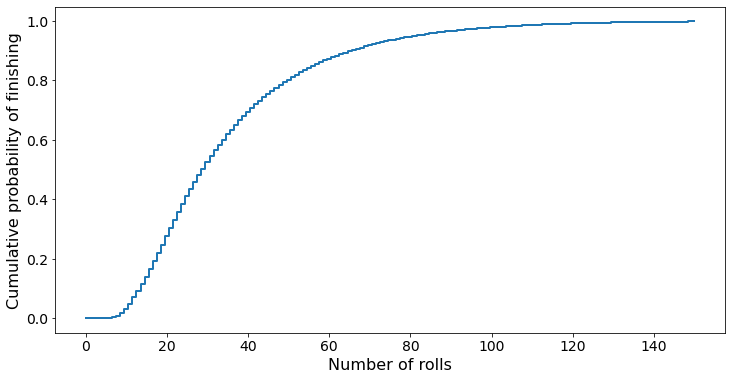

In [33]:
plt.step(range(N+1), q[100, :], where='mid')
plt.xlabel('Number of rolls')
plt.ylabel('Cumulative probability of finishing')
plt.show()

And the arrival times become:

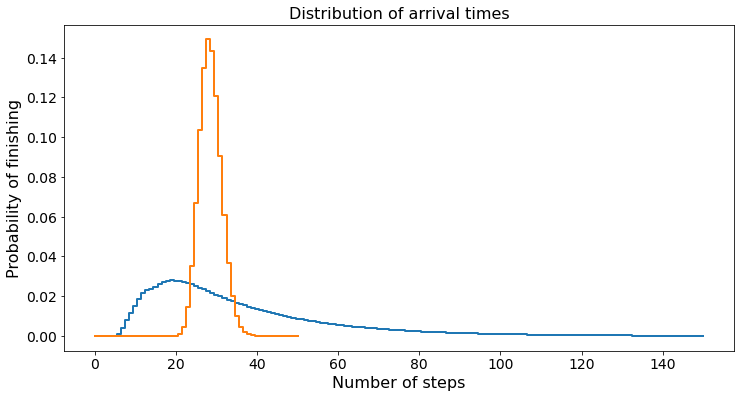

In [34]:
arrival_q = np.gradient(q[100, :])

plt.step(range(N+1), arrival_q, where='mid')
plt.step(range(len(arrival)), arrival, where='mid')
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps')
plt.ylabel('Probability of finishing')
plt.show()

From the plot, we see that the probability function for the empty board is much thinner and higher, while for the normal board it is lower and more spread out. Note that because this is a probability distribution, the sum under the curve must be 1. And so the height and width of the curves are coupled.

The reason the probability of the normal board is more spread out is that adding the chutes and ladders is adding *variance* to the game. With the chutes and ladders we can get lucky and finish early, or we can get unlucky and spend longer to finish. This is reflected in the probability distributions.

In addition to being more spread out, the curve for the normal board has more of its weight towards the left. This means that on *average* we will tend to finish in a fewer number of rolls on the normal board than on the empty board. This means that there is a benefit to the player for having the chutes and ladders added. This is because the benefit of the ladders outweighs the negative cost of the chutes. This is probably intentional from the game designers, as having more ladders than chutes is probably more fun to those playing the game.


#### Comparing the Random walk and the Markov Chain

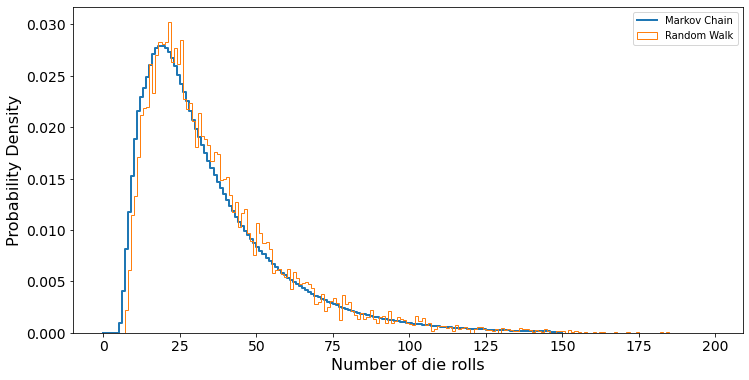

In [35]:
plt.step(range(N+1), arrival_q)
plt.hist(games, bins=range(200), density=True, histtype='step')
plt.xlabel('Number of die rolls')
plt.ylabel('Probability Density')
plt.legend(['Markov Chain', 'Random Walk'])
plt.show()

### Adding a new Rule

Let us go one step further than we did in the exercises. In many variants of chutes and ladders, a player who rolls a six immediately gets another throw.

In our Monte Carlo simulation of the game, i.e., the random walk, we can simply add this rule with an extra if-test.

In [36]:
def one_game_sixes():
    position = 0
    turns = 0

    while position < 100:
        rolls = [np.random.randint(1, 7)]
        while rolls[-1] == 6:
            rolls.append(np.random.randint(1, 7))

        for roll in rolls:
            position += roll
            if position in ladders:
                position = ladders[position]
            elif position in chutes:
                position = chutes[position]

        turns += 1

    return turns

Normal game
Lowest number: 7
Highest number: 342
Average number: 35.87358

Rolling six gives new roll:
Lowest number: 3
Highest number: 244
Average number: 30.10804



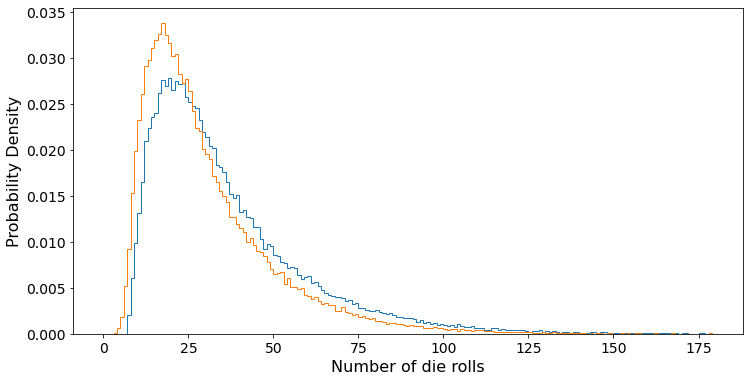

In [37]:
N = 100000

games = [one_game() for i in range(N)]
games_sixes = [one_game_sixes() for i in range(N)]

print("Normal game")
print(f"Lowest number: {np.min(games)}")
print(f"Highest number: {np.max(games)}")
print(f"Average number: {np.mean(games)}")
print()

print("Rolling six gives new roll:")
print(f"Lowest number: {np.min(games_sixes)}")
print(f"Highest number: {np.max(games_sixes)}")
print(f"Average number: {np.mean(games_sixes)}")
print()

plt.hist(games, bins=range(180), density=True, histtype='step')
plt.hist(games_sixes, bins=range(180), density=True, histtype='step')
plt.xlabel('Number of die rolls')
plt.ylabel('Probability Density')
plt.show()

We thus see that adding the re-roll rule reduces the number of rolls we need to get to the finish line by an average of 6. This seems reasonable, as the original average was about 36 throws, and so we would expect about $36/6$ rolls of six.


How can we add this rule to our Markov chain? Here things become a lot more complex, as the propagator matrix denotes the probability of moving from state $j$ to state $i$ in one turn. However, with the reroll rule, we can suddenly get from the starting square $j=0$ to literally any other square on the board in one turn. This means constructing the propagator matrix will be a much larger challenge than before.

We now see that adding a fairly simple rule had little to no impact on the challenge of modeling the problem with Monte Carlo simulation. However, modeling it as a markov chain has been a lot more challenging.